In [ ]:
# in this notebook I will try and use an autoencoder to build
# a reduced representation for more than one model

In [1]:
# tensorflow
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# fix the seed for consistent interpretation of the results
import random as python_random
python_random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

Using TensorFlow v2.4.1


In [ ]:
from tqdm.notebook import tqdm

In [2]:
from scrinet.interfaces import lalutils

import lal
import lalsimulation as lalsim

import utils

In [3]:
import phenom

In [43]:
# https://stackoverflow.com/questions/59563085/how-to-stop-training-when-it-hits-a-specific-validation-accuracy
class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, val):
        super(ThresholdCallback, self).__init__()
        self.val = val
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') <= self.val:
            self.model.stop_training = True

In [4]:
def gen_model_waveforms(approx, qlist, npts, t_min, t_max, nrfiles=None):
    if approx == "NR":
        return [utils.WaveformGeneration(nrfile=nrfiles[key], npts=npts, t_min=t_min, t_max=t_max) for key in nrfiles]
    else:
        lal_approx = lalsim.GetApproximantFromString(approx)
        return [utils.WaveformGeneration(approximant=lal_approx, q=q, npts=npts, t_min=t_min, t_max=t_max) for q in qlist]

In [752]:
def make_training_set(wfs, attr, scale_by_eta=False):
    """
    make a numpy array of training data
    """
    x = np.array([wf.__getattribute__('q') for wf in wfs])
    y = np.array([wf.__getattribute__(attr) for wf in wfs])
    
    if scale_by_eta:
        eta = phenom.eta_from_q(x)[:, np.newaxis]
        return {'x':x, 'y':y/eta}
    else:
        return {'x':x, 'y':y}

In [820]:
# define hyper-parameters

# approxs = ["SEOBNRv4_opt", "IMRPhenomB", "IMRPhenomC", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "SEOBNRv4", "SEOBNRv2", 'IMRPhenomT', 'IMRPhenomXAS', "NR"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "NR"]
# approxs = ["SEOBNRv4_opt", "SEOBNRv4"]
approxs = ["SEOBNRv4_opt", "IMRPhenomD"]
# approxs = ["SEOBNRv4_opt"]


start_approx = approxs[0]
q_min = 1
q_max = 19
# q_min = 19
# q_max = 30
dq = 0.25

q_arr = np.arange(q_min, q_max, dq)

# time points
npts=1000
# npts=5000
# t_min=-500
t_min=-2000
t_max=75

# data_to_model = 'Reh22'
# data_to_model = 'amp'
data_to_model = 'phase'
# data_to_model = 'freq'

In [821]:
model_wfs = {}
for approx in approxs:
    model_wfs.update({approx:gen_model_waveforms(approx, q_arr, npts, t_min=t_min, t_max=t_max)})

In [822]:
# model_grb_ts: the greedy reduced basis training set for each model
model_ts = {}
for approx in approxs:
    model_ts.update({approx:make_training_set(model_wfs[approx], data_to_model, scale_by_eta=False)})

In [823]:
common_times = model_wfs[start_approx][0].times

In [824]:
model_ts.keys()

dict_keys(['SEOBNRv4_opt', 'IMRPhenomD'])

In [825]:
model_ts[start_approx].keys()

dict_keys(['x', 'y'])

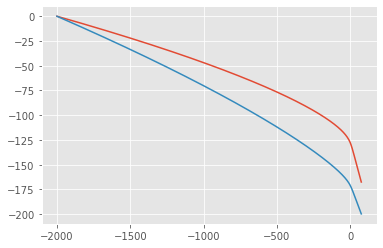

In [826]:
plt.figure()
plt.plot(common_times, model_ts[start_approx]['y'][0])
plt.plot(common_times, model_ts[start_approx]['y'][-1])

In [827]:
# the training set will just be the concatonated list of all waveforms
# from each model
train_x = np.concatenate([model_ts[k]['x'] for k in model_ts.keys()])
train_y = np.concatenate([model_ts[k]['y'] for k in model_ts.keys()])

In [828]:
train_y.shape

(144, 1000)

In [829]:
train_y.shape

(144, 1000)

In [830]:
train_x.shape

(144,)

In [831]:
# plt.figure(figsize=(14, 8))
# for i in range(train_y.shape[0]):
#     plt.plot(common_times, train_y[i], label=train_x[i])
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# # plt.xlim(-100, 100)

# setting up the autoencoder

In [1020]:
def build_encoder(input_shape, latent_dim, act="relu"):
    # build the encoder
    timeseries_input = keras.Input(shape=(input_shape, ))
    x = layers.Dense(128, activation=act)(timeseries_input)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(64, activation=act)(x)
    x = layers.Dense(16, activation=act)(x)
#     x = layers.Dense(16, activation="tanh")(x)
    latent_output = layers.Dense(latent_dim)(x)
    encoder_AE = keras.Model(timeseries_input, latent_output)
#     encoder_AE.summary()
    
    return encoder_AE

In [1021]:
def build_decoder(latent_dim, act="relu"):
    # build the decoder
    latent_input = keras.Input(shape=(latent_dim,))
    x = layers.Dense(16, activation=act)(latent_input)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(64, activation=act)(x)
    x = layers.Dense(128, activation=act)(x)
#     x = layers.Dense(128, activation="tanh")(x)
    timeseries_output = layers.Dense(input_shape, activation="linear")(x)
    decoder_AE = keras.Model(latent_input, timeseries_output)
#     decoder_AE.summary()
    
    return decoder_AE

In [1022]:
def build_and_compile_autoencoder(input_shape, encoder_AE, decoder_AE, opt):
    # build the AE
    timeseries_input = keras.Input(shape=(input_shape, ))
    latent = encoder_AE(timeseries_input)
    timeseries_output = decoder_AE(latent)
    ae_model = keras.Model(timeseries_input, timeseries_output)
#     ae_model.summary()

    ae_model.compile(optimizer=opt, loss='mse')
    
    return ae_model

In [1041]:
# latent dimension
latent_dim = 2
# latent_dim = 3
# latent_dim = 4
# latent_dim = 10
# latent_dim = 100

In [1042]:
act = "relu"
# act = "tanh"

In [1043]:
input_shape = train_y.shape[1] # number of time points

In [1044]:
learning_rate=0.001
amsgrad=True
# opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=amsgrad)
# opt = tfa.optimizers.NovoGrad(learning_rate=learning_rate, amsgrad=amsgrad)
opt = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate)
# opt = tfa.optimizers.Yogi(learning_rate=learning_rate)
# opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
# opt = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
# opt = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
# opt = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

# opt = tfa.optimizers.Lookahead(opt)

encoder_AE = build_encoder(input_shape, latent_dim, act)
decoder_AE = build_decoder(latent_dim, act)
ae_model = build_and_compile_autoencoder(input_shape, encoder_AE, decoder_AE, opt)
# encoder_AE.summary()
# decoder_AE.summary()
# ae_model.summary()


callbacks = []

# first_decay_steps = 400
first_decay_steps = 400
# learning_rate_fn = tf.keras.experimental.CosineDecayRestarts(learning_rate, first_decay_steps)

# learning_rate_fn = tfa.optimizers.ExponentialCyclicalLearningRate(learning_rate, 1e-8, first_decay_steps)
learning_rate_fn = tfa.optimizers.ExponentialCyclicalLearningRate(1e-8, learning_rate, first_decay_steps)

callbacks.append(tf.keras.callbacks.LearningRateScheduler(learning_rate_fn))

tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
callbacks.append(tqdm_callback)

callbacks.append(ThresholdCallback(1e-3))

In [1045]:
%%time
# train the AE
ae_history = ae_model.fit(train_y, train_y, epochs=10000, callbacks=callbacks, batch_size=32, verbose=0)
# , validation_split=0.2


CPU times: user 4min 18s, sys: 2min 17s, total: 6min 35s
Wall time: 1min 59s


In [1048]:
plt.figure()
plt.plot(ae_history.history['lr'])
plt.yscale('log')

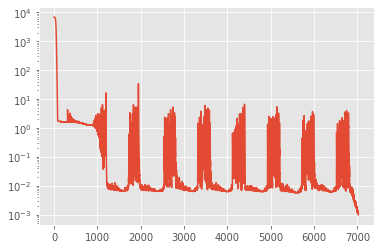

In [1049]:
plt.figure()
plt.plot(ae_history.history['loss'])
# plt.plot(ae_history.history['val_loss'])
plt.yscale('log')

## check out the latent space

In [1050]:
train_encodings_AE = encoder_AE.predict(train_y)

In [1051]:
train_encodings_AE.shape

(144, 2)

In [1052]:
# train_encodings_AE

In [1053]:
plt.figure(figsize=(14, 8))
plt.plot(train_x, train_encodings_AE, 'o')
plt.xlabel('physical parameter')
plt.ylabel('latent parameter')

Text(0, 0.5, 'latent parameter')

In [1054]:
# scatter plot of encodings in the latent space
def scatter_plot_encodings_latent(encodings, labels):
    plt.figure(dpi=100)
    scat = plt.scatter(encodings[:, 0], encodings[:, 1], c=labels, s=20, cmap='Paired')
    plt.gca().add_artist(plt.legend(*scat.legend_elements(), 
                         title='Mass-ratio', bbox_to_anchor=(1.5, 1.)))
    plt.xlabel('Feature X')
    plt.ylabel('Feature Y')
#     plt.gca().set_aspect(1)
#     plt.xlim(-1.5, 1.5)
#     plt.ylim(-1.5, 1.5)
    plt.show()
    
# scatter plot of encodings by AE
scatter_plot_encodings_latent(train_encodings_AE, train_x)

In [1055]:
def plot_prediction(index, n_samples=0):
    
    latent_true = train_encodings_AE[index][np.newaxis,:]
    
    if n_samples:
        rvs = np.random.uniform(latent_true-0.1, latent_true+0.1, size=(n_samples, latent_dim))
        yhats = decoder_AE.predict(rvs)
        yhats_min = np.min(yhats, axis=0)
        yhats_max = np.max(yhats, axis=0)
    
    plt.figure(figsize=(18, 10))
    
    if n_samples:
        plt.fill_between(common_times, y1=yhats_min, y2=yhats_max, color='g', alpha=0.2)
        
        for yh in yhats:
            plt.plot(common_times, yh, lw=1, color='k', alpha=0.2)
    
    plt.plot(common_times, train_y[index], lw=2)
    plt.plot(common_times, decoder_AE.predict(latent_true)[0], ls='--', lw=2)
    
    plt.title(f'mass-ratio: {train_x[index]}')
    
#     plt.xlim(-100, 100)
#     plt.yscale('log')
    plt.show()
    plt.close()

In [1059]:
plot_prediction(0, n_samples=0)

# loop over optimisers

In [619]:
def run_loop_over_optimisers():
    # latent_dim = 2
    latent_dim = 3
    act = "relu"
    # act = "tanh"
    input_shape = train_y.shape[1] # number of time points
    learning_rate=0.01
    amsgrad=True
    lookahead=False
    
    opts = [
        tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=amsgrad),
        tfa.optimizers.NovoGrad(learning_rate=learning_rate, amsgrad=amsgrad),
        tfa.optimizers.RectifiedAdam(learning_rate=learning_rate),
        tfa.optimizers.Yogi(learning_rate=learning_rate),
#         tfa.optimizers.ConditionalGradient(learning_rate=learning_rate),
        tfa.optimizers.LAMB(learning_rate=learning_rate),
        tfa.optimizers.LazyAdam(learning_rate=learning_rate),
#         tfa.optimizers.ProximalAdagrad(learning_rate=learning_rate),
#         tf.keras.optimizers.Adadelta(learning_rate=learning_rate),
#         tf.keras.optimizers.Adagrad(learning_rate=learning_rate),
        tf.keras.optimizers.Adamax(learning_rate=learning_rate),
#         tf.keras.optimizers.Nadam(learning_rate=learning_rate),
#         tf.keras.optimizers.Ftrl(learning_rate=learning_rate),
#         tf.keras.optimizers.SGD(learning_rate=learning_rate),
        tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    ]

    results = []
    
    for opt in tqdm(opts):
        print(opt._name)
        
        if lookahead:
            opt = tfa.optimizers.Lookahead(opt)

        encoder_AE = build_encoder(input_shape, latent_dim, act)
        decoder_AE = build_decoder(latent_dim, act)
        ae_model = build_and_compile_autoencoder(input_shape, encoder_AE, decoder_AE, opt)

        callbacks = []
        first_decay_steps = 40
#         learning_rate_fn = tf.keras.experimental.CosineDecayRestarts(learning_rate, first_decay_steps)
#         learning_rate_fn = tfa.optimizers.ExponentialCyclicalLearningRate(learning_rate, 1e-8, first_decay_steps)
        learning_rate_fn = tfa.optimizers.ExponentialCyclicalLearningRate(
            initial_learning_rate=1e-9,
            maximal_learning_rate=learning_rate,
            step_size=first_decay_steps,
            scale_mode="cycle")



        callbacks.append(tf.keras.callbacks.LearningRateScheduler(learning_rate_fn))
        tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
        callbacks.append(tqdm_callback)
        callbacks.append(ThresholdCallback(1e-6))
        
        # train the AE
        ae_history = ae_model.fit(train_y, train_y, epochs=1000, callbacks=callbacks, batch_size=32, verbose=0)
        
        results.append({'model':ae_model, 'history':ae_history})
        
    return results

In [620]:
%%time
results = run_loop_over_optimisers()

Adam



NovoGrad



RectifiedAdam



Yogi



LAMB



LazyAdam



Adamax



RMSprop




CPU times: user 2min 15s, sys: 36.7 s, total: 2min 51s
Wall time: 1min 3s


In [621]:
def get_name_of_best_opt(results):
    best_index = np.argmin([np.min(result['history'].history['loss']) for result in results])
    return results[best_index]['model'].optimizer._name

In [622]:
get_name_of_best_opt(results)

'RectifiedAdam'

In [623]:
plt.figure(figsize=(14, 8))
for result in results:
    plt.plot(result['history'].history['lr'], label=result['model'].optimizer._name)
plt.yscale('log')
plt.legend()

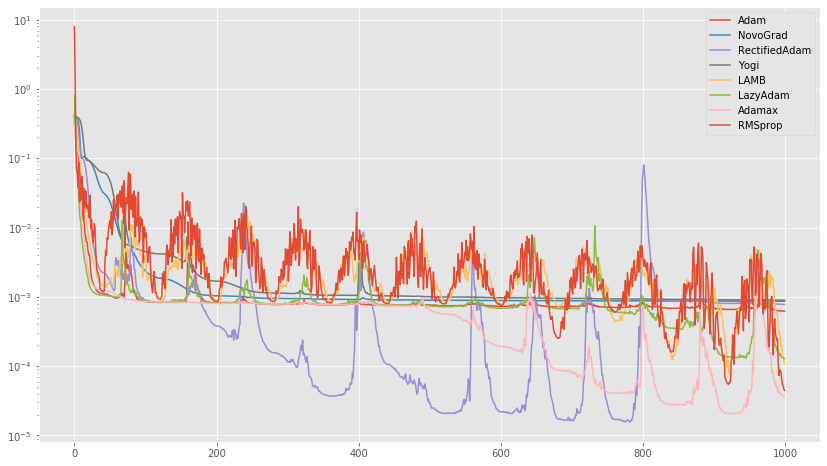

In [624]:
plt.figure(figsize=(14, 8))
for result in results:
    plt.plot(result['history'].history['loss'], label=result['model'].optimizer._name)
plt.yscale('log')
plt.legend()